# Content-based recommendation

In this notebook, we will address the fundamental question of our research topic: "Which anime should you watch next?" This time, our approach will exclusively utilize a content-based recommendation system.

In [142]:
import pandas as pd

animes_df = pd.read_csv("data/anime.csv")

animes_df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


First, let's clean our data to make it more suitable and ready for use in our recommender system. For feature selection, we will combine all our features into a single string. This approach is important because preferences can vary; some users might not only consider the genre of animes but also take into account the number of episodes, type, and ratings. For example, someone who prefers shorter, related animes like *Shingeki no Kyojin* (Attack on Titan) might not be interested in longer series such as *One Piece* or *Bleach*, and vice versa.

In [144]:
import html

animes_df["name"] = animes_df["name"].apply(html.unescape) # cleaning the names

animes_df['genre'] = animes_df['genre'].fillna('') # Filling NaNs with empty string
genres_str = animes_df['genre'].str.split(',').astype(str)
animes_df = animes_df[animes_df['episodes'] != 'Unknown'] # keep those who have some number of episodes
animes_df.dropna() # same as to what we did in eda

# Combine all features into a single string
animes_df['combined_features'] = animes_df.apply(
    lambda x: f"genre:{x['genre']} type:{x['type']} episodes:{x['episodes']} rating:{x['rating']} members:{x['members']}",
    axis=1
)

# Filling NaNs with empty string
animes_df['combined_features'] = animes_df['combined_features'].fillna('')

animes_df.head()

,anime_id,name,genre,type,episodes,rating,members,combined_features
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,"genre:Drama, Romance, School, Supernatural typ..."
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,"genre:Action, Adventure, Drama, Fantasy, Magic..."
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262,"genre:Action, Comedy, Historical, Parody, Samu..."
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572,"genre:Sci-Fi, Thriller type:TV episodes:24 rat..."
4,9969,Gintama',"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266,"genre:Action, Comedy, Historical, Parody, Samu..."


To build our similarity vectors, we are using TF-IDF to construct our vectorized features. Additionally, since we need to assign a value of 1 for recommended anime and 0 for non-recommended anime, we are utilizing the sigmoid kernel provided by the Scikit-learn library.

In [145]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import sigmoid_kernel

tfv = TfidfVectorizer(min_df=3,  max_features=None, 
        strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
        ngram_range=(1, 3),
        stop_words = 'english')

tfv_matrix = tfv.fit_transform(animes_df['combined_features'])
sig = sigmoid_kernel(tfv_matrix, tfv_matrix)

Finally, our recommendation function takes the name of an anime and returns 10 most similar animes based on the sorted similarities extracted from the similarity matrix generated from the TF-IDF and the sigmoid kernel

In [146]:
def content_based_recommender(title, sim=sig):
    # Get the index corresponding to original_title
    indices = pd.Series(animes_df.index, index=animes_df['name']).drop_duplicates()
    idx = indices[title]

    # Get the similarity scores 
    sim_scores = list(enumerate(sim[idx]))

    # Sort the animes 
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Scores of the 10 most similar animes
    sim_scores = sim_scores[1:11]

    # Animes indices
    anime_indices = [i[0] for i in sim_scores]

    # Top 10 most similar Animes
    return pd.DataFrame({
                        'Anime name': animes_df['name'].iloc[anime_indices].values,
                        'Rating': animes_df['rating'].iloc[anime_indices].values,
                        'Members': animes_df['members'].iloc[anime_indices].values,
                        'Episodes': animes_df['episodes'].iloc[anime_indices].values,
                        'Genre': animes_df['genre'].iloc[anime_indices].values,
                        'Type': animes_df['type'].iloc[anime_indices].values
                        })

In [154]:
random_anime = animes_df.sample(n=1)
name = random_anime["name"].values[0] 
print("Recommendations for:",name, random_anime['combined_features'].values[0])

content_based_recommender(name)

Recommendations for: Choujin Locke: Lord Leon genre:Action, Sci-Fi, Super Power type:OVA episodes:3 rating:6.37 members:483


,Anime name,Rating,Members,Episodes,Genre,Type
0,Hoshi no Ko Chobin,6.36,231,26,"Adventure, Sci-Fi",TV
1,Diabolus: Kikoku,6.36,3250,2,Hentai,OVA
2,Shin Hitou Meguri,6.36,2702,2,Hentai,OVA
3,Wonder 3 Pilot,6.36,63,1,"Action, Adventure, Comedy, Sci-Fi",Special
4,Last Exile: Ginyoku no Fam Recaps,6.56,4621,2,"Action, Adventure, Sci-Fi",Special
5,Wakakusa Monogatari: Nan to Jo-sensei Specials,6.36,138,2,"Drama, Historical, School, Slice of Life",Special
6,"Subarashii Sekai Ryokou: Alaska no Tabi ""Daigo...",8.00,62,2,"Adventure, Sci-Fi",Special
7,Gatchaman Crowds: Embrace,7.50,10757,1,"Adventure, Sci-Fi",Special
8,Cele Kano,6.36,1947,2,Hentai,OVA
9,Imouto de Ikou!,6.36,2457,2,Hentai,OVA


As we may not have a specific ground truth to evaluate our recommendation system, we are employing alternative techniques. We combine clustering methods to group animes into clusters and then evaluate the quality of our recommendations. For instance, using the anime Choujin Locke: Lord Leon, we verify whether the recommended animes belong to the same cluster as the selected anime. To achieve this, we utilize DBSCAN and Agglomerative Clustering, both employing a cosine-based metric for distance.

Finally, we implement a function to compute Cluster Purity (%), which quantifies the percentage of recommended animes that are in the same cluster as the initial anime provided.

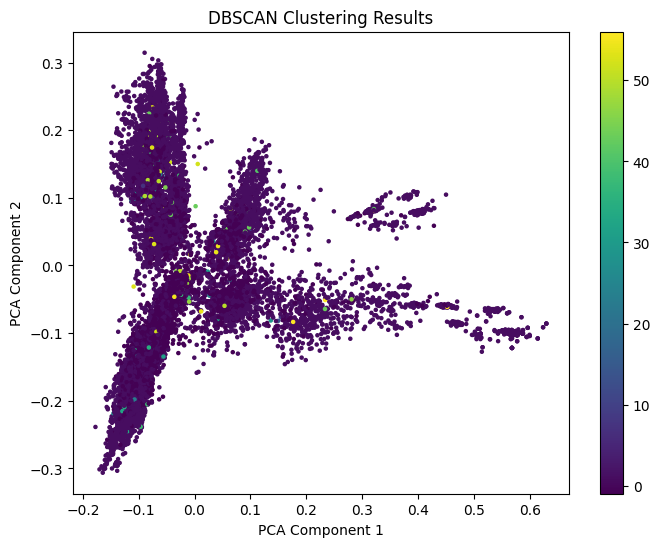

In [170]:
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5, metric='cosine')
dbscan_labels = dbscan.fit_predict(tfv_matrix)

# Visualization for DBSCAN
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(tfv_matrix)

plt.figure(figsize=(8, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=dbscan_labels, cmap='viridis', s=5)
plt.colorbar()
plt.title('DBSCAN Clustering Results')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# Assign DBSCAN clusters to the DataFrame
animes_df['dbscan_cluster'] = dbscan_labels

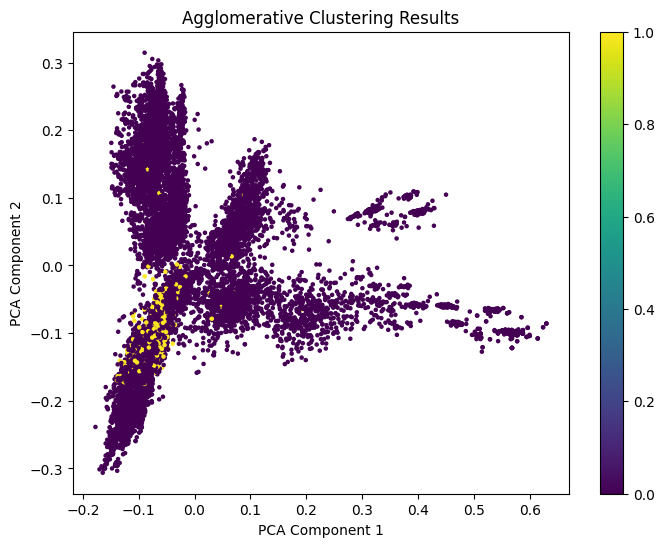

In [169]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Convert tfv_matrix to dense format
tfv_matrix_dense = tfv_matrix.toarray()

# Agglomerative Clustering
agg_clustering = AgglomerativeClustering(metric='cosine', linkage='average')
agg_labels = agg_clustering.fit_predict(tfv_matrix_dense)

# Visualization for Agglomerative Clustering
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(tfv_matrix_dense)

plt.figure(figsize=(8, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=agg_labels, cmap='viridis', s=5)
plt.colorbar()
plt.title('Agglomerative Clustering Results')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# Assign Agglomerative clusters to the DataFrame
animes_df['agg_cluster'] = agg_labels

In [172]:
import numpy as np

def validate_recommendations_with_clustering(title, cluster_column, content_based_recommender=content_based_recommender):

    # Get the cluster of the input anime
    input_cluster = animes_df.loc[animes_df['name'] == title, cluster_column].values[0]
    
    # Get recommendations
    recommended_animes = content_based_recommender(title)['Anime name'].values
    
    # Check if recommendations are in the same cluster
    recommended_clusters = animes_df.loc[animes_df['name'].isin(recommended_animes), cluster_column].values
    same_cluster_count = np.sum(recommended_clusters == input_cluster)
    
    # Return validation results
    return {
        'Recommendations in Same Cluster': same_cluster_count,
        'Cluster Purity (%)': (same_cluster_count / len(recommended_clusters)) * 100
    }

In [175]:
dbscan_validation = validate_recommendations_with_clustering(
    title=name, 
    cluster_column='dbscan_cluster'
)

agg_validation = validate_recommendations_with_clustering(
    title=name, 
    cluster_column='agg_cluster'
)

print("DBSCAN Validation:", dbscan_validation)
print("Agglomerative Validation:", agg_validation)

DBSCAN Validation: {'Recommendations in Same Cluster': np.int64(10), 'Cluster Purity (%)': np.float64(100.0)}
Agglomerative Validation: {'Recommendations in Same Cluster': np.int64(10), 'Cluster Purity (%)': np.float64(100.0)}
